In [1]:
import tensorflow as tf
import pickle
from keras.layers import (
    Input,
    Dense,
    Dense,
    Conv1D,
    Flatten, 
    Embedding,    
    Dropout, 
    Conv1D,
    MaxPooling1D,
    Bidirectional,
    LSTM)
from keras import Model
import keras
from imblearn.over_sampling import SMOTE
%run constants.py

tf.random.set_seed(
    SEED
)
import os
import numpy
from numpy.random import seed 
seed(SEED)
import matplotlib.pyplot as plt

In [2]:
def load_variables(timestep: int):
    f = os.path.basename(X_TRAIN_INPUT_SAVE_FILE_VEC_SINGLE_TIMESTEP)
    X_TRAIN_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(X_TEST_INPUT_SAVE_FILE_VEC_SINGLE_TIMESTEP)
    X_TEST_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(X_VAL_INPUT_SAVE_FILE_VEC_SINGLE_TIMESTEP)
    X_VAL_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 

   
    f = os.path.basename(Y_TRAIN_INPUT_SAVE_FILE)
    Y_TRAIN_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(Y_TEST_INPUT_SAVE_FILE)
    Y_TEST_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(Y_VAL_INPUT_SAVE_FILE)
    Y_VAL_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 

    f = os.path.basename(EMBEDDING_MATRIX_SAVE_FILE)
    EMBEDDING_MATRIX_DIR= os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(VOCAB_SAVE_FILE)
    VOCAB_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(TRAIN_CORPORA)
    TRAIN_CORPORA_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 
    return X_TRAIN_DIR, X_VAL_DIR, X_TEST_DIR, Y_TRAIN_DIR, Y_VAL_DIR, Y_TEST_DIR, EMBEDDING_MATRIX_DIR, VOCAB_DIR, TRAIN_CORPORA_DIR

In [3]:
def get_variables(X_TRAIN_DIR, Y_TRAIN_DIR, X_VAL_DIR, Y_VAL_DIR, X_TEST_DIR, Y_TEST_DIR, EMBEDDING_DIR):
        
        with open(X_TRAIN_DIR, "rb") as f:
                x_train = pickle.load(f)

        with open(Y_TRAIN_DIR, "rb") as f:
                y_train = pickle.load(f)

        with open(X_VAL_DIR, "rb") as f:
                x_val = pickle.load(f)

        with open(Y_VAL_DIR, "rb") as f:
                y_val = pickle.load(f)

        with open(X_TEST_DIR, "rb") as f:
                x_test = pickle.load(f)

        with open(Y_TEST_DIR, "rb") as f:
                y_test = pickle.load(f)

        with open(EMBEDDING_DIR, "rb") as f:
                embedding_matrix = pickle.load(f)
                
        embedding_layer = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights = [embedding_matrix], trainable=False)
        return x_train, y_train, x_val, y_val, x_test, y_test, embedding_matrix, embedding_layer

In [4]:
def balance_training_dataset(x_train, y_train):

    print(f"Before OverSampling, counts of label '1': {sum(y_train == 1)}")
    print(f"Before OverSampling, counts of label '0': {sum(y_train == 0)}")

    if BALANCE_DATA:
        arr = x_train
        print(arr.shape)
        sm = SMOTE(random_state=SEED)
        x_train_bal, y_train = sm.fit_resample(arr, y_train.ravel())
        print(f"After OverSampling, the shape of train_X: {x_train_bal.shape}")
        print(f"After OverSampling, the shape of train_y: {y_train.shape}")
        print(f"After OverSampling, counts of label '1': {sum(y_train == 1)}")
        print(f"After OverSampling, counts of label '0': {sum(y_train == 0)}")
        x_train = x_train_bal
    return x_train, y_train


In [5]:

def plot_graph(history):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    return plt

# CNN Classifier

In [6]:

def cnn_model(embedding_layer, file_suffix):

  X_indices = Input(shape=(MAX_SEQUENCE_LENGTH,))

  embeddings = embedding_layer(X_indices)

  X = Conv1D(filters=400, kernel_size=5, padding="valid")(embeddings)

  X = MaxPooling1D()(X)
  
  X = Dropout(0.6)(X)

  X = Flatten()(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X, name = f'cnn{file_suffix}')

  return model

# LSTM Classifier

In [7]:
def lstm_model(embedding_layer, file_suffix):

  X_indices = Input(shape=(MAX_SEQUENCE_LENGTH,))

  embeddings = embedding_layer(X_indices)

  X = LSTM(60)(embeddings)
  
  X = Dropout(0.3)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X, name = f'lstm{file_suffix}')

  return model

# LSTM Stacked Classifier

In [8]:
def stacked_lstm_model(embedding_layer, file_suffix):

  X_indices = Input(shape=(MAX_SEQUENCE_LENGTH,))

  embeddings = embedding_layer(X_indices)

  X = LSTM(60, return_sequences=True)(embeddings)

  X = Dropout(0.3)(X)

  X = LSTM(60)(X)

  X = Dropout(0.3)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X, name = f'lstm_stacked{file_suffix}')

  return model

# BiLSTM 

In [9]:
def bi_lstm_model(embedding_layer, file_suffix):

  X_indices = Input(shape=(MAX_SEQUENCE_LENGTH,))

  embeddings = embedding_layer(X_indices)

  X = Bidirectional(LSTM(60))(embeddings)
  
  X = Dropout(0.3)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X, name = f'bilstm{file_suffix}')

  return model

# BiLSTM Stacked Classifier

In [10]:
def stacked_bi_lstm_model(embedding_layer, file_suffix):

  X_indices = Input(shape=(MAX_SEQUENCE_LENGTH,))

  embeddings = embedding_layer(X_indices)

  X = Bidirectional(LSTM(60, return_sequences=True))(embeddings)

  X = Dropout(0.3)(X)

  X = Bidirectional(LSTM(60))(X)

  X = Dropout(0.3)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X, name = f'bilstm_stacked{file_suffix}')

  return model

In [11]:
def run_model(model_type: str, x_train, y_train, x_val, y_val, x_test, y_test, embedding_layer, file_suffix, timestep):

    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = tf.metrics.BinaryAccuracy()
    
    if model_type == 'cnn':
        model = cnn_model(embedding_layer = embedding_layer, file_suffix=file_suffix)

    if model_type == 'lstm':
        model = lstm_model(embedding_layer = embedding_layer, file_suffix=file_suffix)

    if model_type == 'stacked_lstm':
        model = stacked_lstm_model(embedding_layer = embedding_layer, file_suffix=file_suffix)

    if model_type == 'bilstm':
        model = bi_lstm_model(embedding_layer = embedding_layer, file_suffix=file_suffix)

    if model_type == 'stacked_bilstm':
        model = stacked_bi_lstm_model(embedding_layer = embedding_layer, file_suffix=file_suffix)


    model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)
    history = model.fit(x=x_train, y=y_train,
                                    validation_data = (x_val, y_val),
                                epochs=NUM_EPOCHS)
    model_save_dir = f"saved_model/{model_type}{file_suffix}"
    model.save(model_save_dir)

    loss, accuracy = model.evaluate(x= x_test, y= y_test)
    graph = plot_graph(history)
    save_file_name: str = f'saved_graphs/{model_type}{file_suffix}.png' 
    graph.savefig(save_file_name)
    return accuracy, loss

x_train_dir: /home/aaron/timeseries_nlp/data/X_train_vec_single_timestep_30.pkl
x_val_dir: /home/aaron/timeseries_nlp/data/X_val_vec_single_timestep_30.pkl
x_test_dir: /home/aaron/timeseries_nlp/data/X_test_vec_single_timestep_30.pkl
y_train_dir: /home/aaron/timeseries_nlp/data/Y_train_30.pkl
y_val_dir: /home/aaron/timeseries_nlp/data/Y_val_30.pkl
y_test_dir: /home/aaron/timeseries_nlp/data/Y_test_30.pkl
-----


2022-08-15 10:11:09.631255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-15 10:11:10.503514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6672 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:03:00.0, compute capability: 7.5
2022-08-15 10:11:10.504345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6671 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:04:00.0, compute capability: 7.5


Before OverSampling, counts of label '1': 1119
Before OverSampling, counts of label '0': 1346
(2465, 200)
After OverSampling, the shape of train_X: (2692, 200)
After OverSampling, the shape of train_y: (2692,)
After OverSampling, counts of label '1': 1346
After OverSampling, counts of label '0': 1346
Epoch 1/30


2022-08-15 10:11:11.612823: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-15 10:11:12.223209: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


85/85 [==============================] - 3s 7ms/step - loss: 0.7205 - binary_accuracy: 0.5030 - val_loss: 0.7026 - val_binary_accuracy: 0.5073
Epoch 2/30
85/85 [==============================] - 0s 5ms/step - loss: 0.7059 - binary_accuracy: 0.5215 - val_loss: 0.6898 - val_binary_accuracy: 0.5657
Epoch 3/30
85/85 [==============================] - 0s 5ms/step - loss: 0.6954 - binary_accuracy: 0.5472 - val_loss: 0.6932 - val_binary_accuracy: 0.5547
Epoch 4/30
85/85 [==============================] - 0s 5ms/step - loss: 0.6869 - binary_accuracy: 0.5453 - val_loss: 0.6848 - val_binary_accuracy: 0.5547
Epoch 5/30
85/85 [==============================] - 0s 5ms/step - loss: 0.6809 - binary_accuracy: 0.5724 - val_loss: 0.6879 - val_binary_accuracy: 0.5474
Epoch 6/30
85/85 [==============================] - 0s 5ms/step - loss: 0.6688 - binary_accuracy: 0.5799 - val_loss: 0.6778 - val_binary_accuracy: 0.5766
Epoch 7/30
85/85 [==============================] - 0s 5ms/step - loss: 0.6635 - binary

INFO:tensorflow:Assets written to: saved_model/cnn_i1_o30/assets


INFO:tensorflow:Assets written to: saved_model/cnn_i1_o30/assets


22/22 [==============================] - 0s 3ms/step - loss: 0.6362 - binary_accuracy: 0.6584
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for cnn
Loss: 0.6362170577049255
Accuracy: 0.6583941578865051
Epoch 1/30
85/85 [==============================] - 3s 18ms/step - loss: 0.6987 - binary_accuracy: 0.4837 - val_loss: 0.6929 - val_binary_accuracy: 0.6058
Epoch 2/30
85/85 [==============================] - 1s 14ms/step - loss: 0.6961 - binary_accuracy: 0.5227 - val_loss: 0.6925 - val_binary_accuracy: 0.6022
Epoch 3/30
85/85 [==============================] - 1s 15ms/step - loss: 0.6950 - binary_accuracy: 0.5249 - val_loss: 0.6922 - val_binary_accuracy: 0.6095
Epoch 4/30
85/85 [==============================] - 1s 15ms/step - loss: 0.6932 - binary_accuracy: 0.5271 - val_loss: 0.6920 - val_binary_accuracy: 0.6058
Epoch 5/30
85/85 [==============================] - 1s 15ms/step - loss: 0.6927 - binary_accuracy: 0.5349 - val_loss: 0.6921 - val_binary_a

INFO:tensorflow:Assets written to: saved_model/lstm_i1_o30/assets


INFO:tensorflow:Assets written to: saved_model/lstm_i1_o30/assets


22/22 [==============================] - 0s 6ms/step - loss: 0.6878 - binary_accuracy: 0.6029
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for lstm
Loss: 0.6877896785736084
Accuracy: 0.6029196977615356
Epoch 1/30
85/85 [==============================] - 5s 32ms/step - loss: 0.6947 - binary_accuracy: 0.4874 - val_loss: 0.6925 - val_binary_accuracy: 0.4124
Epoch 2/30
85/85 [==============================] - 2s 24ms/step - loss: 0.6941 - binary_accuracy: 0.4974 - val_loss: 0.6923 - val_binary_accuracy: 0.6058
Epoch 3/30
85/85 [==============================] - 2s 24ms/step - loss: 0.6937 - binary_accuracy: 0.5238 - val_loss: 0.6922 - val_binary_accuracy: 0.6058
Epoch 4/30
85/85 [==============================] - 2s 25ms/step - loss: 0.6914 - binary_accuracy: 0.5420 - val_loss: 0.6922 - val_binary_accuracy: 0.6022
Epoch 5/30
85/85 [==============================] - 2s 25ms/step - loss: 0.6910 - binary_accuracy: 0.5390 - val_loss: 0.6923 - val_binary_

INFO:tensorflow:Assets written to: saved_model/stacked_lstm_i1_o30/assets


INFO:tensorflow:Assets written to: saved_model/stacked_lstm_i1_o30/assets


22/22 [==============================] - 0s 11ms/step - loss: 0.6853 - binary_accuracy: 0.6088
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for stacked_lstm
Loss: 0.685271143913269
Accuracy: 0.6087591052055359
Epoch 1/30
85/85 [==============================] - 5s 32ms/step - loss: 0.6921 - binary_accuracy: 0.5375 - val_loss: 0.6964 - val_binary_accuracy: 0.5109
Epoch 2/30
85/85 [==============================] - 2s 25ms/step - loss: 0.6872 - binary_accuracy: 0.5516 - val_loss: 0.6940 - val_binary_accuracy: 0.5255
Epoch 3/30
85/85 [==============================] - 2s 24ms/step - loss: 0.6889 - binary_accuracy: 0.5383 - val_loss: 0.6919 - val_binary_accuracy: 0.5255
Epoch 4/30
85/85 [==============================] - 2s 24ms/step - loss: 0.6868 - binary_accuracy: 0.5513 - val_loss: 0.6904 - val_binary_accuracy: 0.5474
Epoch 5/30
85/85 [==============================] - 2s 24ms/step - loss: 0.6837 - binary_accuracy: 0.5665 - val_loss: 0.6895 - val

INFO:tensorflow:Assets written to: saved_model/bilstm_i1_o30/assets


INFO:tensorflow:Assets written to: saved_model/bilstm_i1_o30/assets


22/22 [==============================] - 0s 12ms/step - loss: 0.6590 - binary_accuracy: 0.6234
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for bilstm
Loss: 0.6590350270271301
Accuracy: 0.6233576536178589
Epoch 1/30
85/85 [==============================] - 9s 58ms/step - loss: 0.6906 - binary_accuracy: 0.5319 - val_loss: 0.6906 - val_binary_accuracy: 0.5620
Epoch 2/30
85/85 [==============================] - 4s 44ms/step - loss: 0.6907 - binary_accuracy: 0.5201 - val_loss: 0.6893 - val_binary_accuracy: 0.5730
Epoch 3/30
85/85 [==============================] - 4s 44ms/step - loss: 0.6889 - binary_accuracy: 0.5267 - val_loss: 0.6878 - val_binary_accuracy: 0.5876
Epoch 4/30
85/85 [==============================] - 4s 44ms/step - loss: 0.6877 - binary_accuracy: 0.5416 - val_loss: 0.6868 - val_binary_accuracy: 0.5949
Epoch 5/30
85/85 [==============================] - 4s 44ms/step - loss: 0.6856 - binary_accuracy: 0.5565 - val_loss: 0.6864 - val_bina

INFO:tensorflow:Assets written to: saved_model/stacked_bilstm_i1_o30/assets


INFO:tensorflow:Assets written to: saved_model/stacked_bilstm_i1_o30/assets


22/22 [==============================] - 0s 21ms/step - loss: 0.6488 - binary_accuracy: 0.6511
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for stacked_bilstm
Loss: 0.6487976312637329
Accuracy: 0.651094913482666
x_train_dir: /home/aaron/timeseries_nlp/data/X_train_vec_single_timestep_60.pkl
x_val_dir: /home/aaron/timeseries_nlp/data/X_val_vec_single_timestep_60.pkl
x_test_dir: /home/aaron/timeseries_nlp/data/X_test_vec_single_timestep_60.pkl
y_train_dir: /home/aaron/timeseries_nlp/data/Y_train_60.pkl
y_val_dir: /home/aaron/timeseries_nlp/data/Y_val_60.pkl
y_test_dir: /home/aaron/timeseries_nlp/data/Y_test_60.pkl
-----
Before OverSampling, counts of label '1': 1314
Before OverSampling, counts of label '0': 1151
(2465, 200)
After OverSampling, the shape of train_X: (2628, 200)
After OverSampling, the shape of train_y: (2628,)
After OverSampling, counts of label '1': 1314
After OverSampling, counts of label '0': 1314
Epoch 1/30
83/83 [==============

INFO:tensorflow:Assets written to: saved_model/cnn_i1_o60/assets


INFO:tensorflow:Assets written to: saved_model/cnn_i1_o60/assets


22/22 [==============================] - 0s 3ms/step - loss: 0.6618 - binary_accuracy: 0.6102
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for cnn
Loss: 0.6617891192436218
Accuracy: 0.6102190017700195
Epoch 1/30
83/83 [==============================] - 4s 19ms/step - loss: 0.6923 - binary_accuracy: 0.4855 - val_loss: 0.6934 - val_binary_accuracy: 0.5511
Epoch 2/30
83/83 [==============================] - 1s 15ms/step - loss: 0.6908 - binary_accuracy: 0.5278 - val_loss: 0.6933 - val_binary_accuracy: 0.5438
Epoch 3/30
83/83 [==============================] - 1s 15ms/step - loss: 0.6899 - binary_accuracy: 0.5339 - val_loss: 0.6932 - val_binary_accuracy: 0.5474
Epoch 4/30
83/83 [==============================] - 1s 15ms/step - loss: 0.6899 - binary_accuracy: 0.5316 - val_loss: 0.6931 - val_binary_accuracy: 0.5474
Epoch 5/30
83/83 [==============================] - 1s 15ms/step - loss: 0.6906 - binary_accuracy: 0.5285 - val_loss: 0.6931 - val_binary_a

INFO:tensorflow:Assets written to: saved_model/lstm_i1_o60/assets


INFO:tensorflow:Assets written to: saved_model/lstm_i1_o60/assets


22/22 [==============================] - 0s 7ms/step - loss: 0.6863 - binary_accuracy: 0.5474
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for lstm
Loss: 0.6863132119178772
Accuracy: 0.5474452376365662
Epoch 1/30
83/83 [==============================] - 5s 37ms/step - loss: 0.6933 - binary_accuracy: 0.4726 - val_loss: 0.6929 - val_binary_accuracy: 0.5547
Epoch 2/30
83/83 [==============================] - 2s 24ms/step - loss: 0.6925 - binary_accuracy: 0.5232 - val_loss: 0.6927 - val_binary_accuracy: 0.5401
Epoch 3/30
83/83 [==============================] - 2s 25ms/step - loss: 0.6908 - binary_accuracy: 0.5308 - val_loss: 0.6926 - val_binary_accuracy: 0.5438
Epoch 4/30
83/83 [==============================] - 2s 25ms/step - loss: 0.6908 - binary_accuracy: 0.5323 - val_loss: 0.6925 - val_binary_accuracy: 0.5474
Epoch 5/30
83/83 [==============================] - 2s 25ms/step - loss: 0.6907 - binary_accuracy: 0.5301 - val_loss: 0.6924 - val_binary_

INFO:tensorflow:Assets written to: saved_model/stacked_lstm_i1_o60/assets


INFO:tensorflow:Assets written to: saved_model/stacked_lstm_i1_o60/assets


22/22 [==============================] - 0s 10ms/step - loss: 0.6879 - binary_accuracy: 0.5504
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for stacked_lstm
Loss: 0.6878628134727478
Accuracy: 0.5503649711608887
Epoch 1/30
83/83 [==============================] - 5s 32ms/step - loss: 0.6942 - binary_accuracy: 0.4947 - val_loss: 0.7025 - val_binary_accuracy: 0.4124
Epoch 2/30
83/83 [==============================] - 2s 24ms/step - loss: 0.6943 - binary_accuracy: 0.5209 - val_loss: 0.7006 - val_binary_accuracy: 0.4197
Epoch 3/30
83/83 [==============================] - 2s 24ms/step - loss: 0.6907 - binary_accuracy: 0.5285 - val_loss: 0.6993 - val_binary_accuracy: 0.4416
Epoch 4/30
83/83 [==============================] - 2s 25ms/step - loss: 0.6901 - binary_accuracy: 0.5205 - val_loss: 0.6978 - val_binary_accuracy: 0.4526
Epoch 5/30
83/83 [==============================] - 2s 24ms/step - loss: 0.6890 - binary_accuracy: 0.5384 - val_loss: 0.6966 - va

INFO:tensorflow:Assets written to: saved_model/bilstm_i1_o60/assets


INFO:tensorflow:Assets written to: saved_model/bilstm_i1_o60/assets


22/22 [==============================] - 0s 11ms/step - loss: 0.6795 - binary_accuracy: 0.5737
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for bilstm
Loss: 0.6794568300247192
Accuracy: 0.5737226009368896
Epoch 1/30
83/83 [==============================] - 10s 58ms/step - loss: 0.6967 - binary_accuracy: 0.4928 - val_loss: 0.6947 - val_binary_accuracy: 0.4891
Epoch 2/30
83/83 [==============================] - 4s 44ms/step - loss: 0.6956 - binary_accuracy: 0.4852 - val_loss: 0.6933 - val_binary_accuracy: 0.5109
Epoch 3/30
83/83 [==============================] - 4s 44ms/step - loss: 0.6944 - binary_accuracy: 0.5099 - val_loss: 0.6921 - val_binary_accuracy: 0.5000
Epoch 4/30
83/83 [==============================] - 4s 44ms/step - loss: 0.6922 - binary_accuracy: 0.5266 - val_loss: 0.6906 - val_binary_accuracy: 0.5255
Epoch 5/30
83/83 [==============================] - 4s 44ms/step - loss: 0.6915 - binary_accuracy: 0.5289 - val_loss: 0.6892 - val_bin

INFO:tensorflow:Assets written to: saved_model/stacked_bilstm_i1_o60/assets


INFO:tensorflow:Assets written to: saved_model/stacked_bilstm_i1_o60/assets


22/22 [==============================] - 0s 19ms/step - loss: 0.6574 - binary_accuracy: 0.6204
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for stacked_bilstm
Loss: 0.6574106216430664
Accuracy: 0.6204379796981812
x_train_dir: /home/aaron/timeseries_nlp/data/X_train_vec_single_timestep_90.pkl
x_val_dir: /home/aaron/timeseries_nlp/data/X_val_vec_single_timestep_90.pkl
x_test_dir: /home/aaron/timeseries_nlp/data/X_test_vec_single_timestep_90.pkl
y_train_dir: /home/aaron/timeseries_nlp/data/Y_train_90.pkl
y_val_dir: /home/aaron/timeseries_nlp/data/Y_val_90.pkl
y_test_dir: /home/aaron/timeseries_nlp/data/Y_test_90.pkl
-----
Before OverSampling, counts of label '1': 1444
Before OverSampling, counts of label '0': 1021
(2465, 200)
After OverSampling, the shape of train_X: (2888, 200)
After OverSampling, the shape of train_y: (2888,)
After OverSampling, counts of label '1': 1444
After OverSampling, counts of label '0': 1444
Epoch 1/30
91/91 [=============

INFO:tensorflow:Assets written to: saved_model/cnn_i1_o90/assets


INFO:tensorflow:Assets written to: saved_model/cnn_i1_o90/assets


22/22 [==============================] - 0s 3ms/step - loss: 0.6826 - binary_accuracy: 0.5898
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for cnn
Loss: 0.6825950741767883
Accuracy: 0.5897810459136963
Epoch 1/30
91/91 [==============================] - 3s 19ms/step - loss: 0.6991 - binary_accuracy: 0.4872 - val_loss: 0.6971 - val_binary_accuracy: 0.4891
Epoch 2/30
91/91 [==============================] - 1s 15ms/step - loss: 0.6973 - binary_accuracy: 0.4768 - val_loss: 0.6962 - val_binary_accuracy: 0.5000
Epoch 3/30
91/91 [==============================] - 1s 14ms/step - loss: 0.6940 - binary_accuracy: 0.5132 - val_loss: 0.6956 - val_binary_accuracy: 0.4818
Epoch 4/30
91/91 [==============================] - 1s 15ms/step - loss: 0.6938 - binary_accuracy: 0.5132 - val_loss: 0.6952 - val_binary_accuracy: 0.4745
Epoch 5/30
91/91 [==============================] - 1s 15ms/step - loss: 0.6918 - binary_accuracy: 0.5332 - val_loss: 0.6950 - val_binary_a

INFO:tensorflow:Assets written to: saved_model/lstm_i1_o90/assets


INFO:tensorflow:Assets written to: saved_model/lstm_i1_o90/assets


22/22 [==============================] - 0s 6ms/step - loss: 0.6869 - binary_accuracy: 0.4993
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for lstm
Loss: 0.6869441866874695
Accuracy: 0.49927008152008057
Epoch 1/30
91/91 [==============================] - 5s 32ms/step - loss: 0.7013 - binary_accuracy: 0.4740 - val_loss: 0.6952 - val_binary_accuracy: 0.4964
Epoch 2/30
91/91 [==============================] - 2s 25ms/step - loss: 0.6984 - binary_accuracy: 0.4702 - val_loss: 0.6939 - val_binary_accuracy: 0.5109
Epoch 3/30
91/91 [==============================] - 2s 25ms/step - loss: 0.6963 - binary_accuracy: 0.4830 - val_loss: 0.6932 - val_binary_accuracy: 0.5255
Epoch 4/30
91/91 [==============================] - 2s 25ms/step - loss: 0.6944 - binary_accuracy: 0.4979 - val_loss: 0.6928 - val_binary_accuracy: 0.4927
Epoch 5/30
91/91 [==============================] - 2s 25ms/step - loss: 0.6931 - binary_accuracy: 0.5260 - val_loss: 0.6926 - val_binary

INFO:tensorflow:Assets written to: saved_model/stacked_lstm_i1_o90/assets


INFO:tensorflow:Assets written to: saved_model/stacked_lstm_i1_o90/assets


22/22 [==============================] - 0s 12ms/step - loss: 0.6860 - binary_accuracy: 0.5080
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for stacked_lstm
Loss: 0.6859698295593262
Accuracy: 0.5080292224884033
Epoch 1/30
91/91 [==============================] - 5s 31ms/step - loss: 0.6969 - binary_accuracy: 0.4941 - val_loss: 0.6966 - val_binary_accuracy: 0.4818
Epoch 2/30
91/91 [==============================] - 2s 24ms/step - loss: 0.6954 - binary_accuracy: 0.4896 - val_loss: 0.6958 - val_binary_accuracy: 0.4854
Epoch 3/30
91/91 [==============================] - 2s 24ms/step - loss: 0.6910 - binary_accuracy: 0.5204 - val_loss: 0.6951 - val_binary_accuracy: 0.5073
Epoch 4/30
91/91 [==============================] - 2s 25ms/step - loss: 0.6905 - binary_accuracy: 0.5093 - val_loss: 0.6945 - val_binary_accuracy: 0.5036
Epoch 5/30
91/91 [==============================] - 2s 24ms/step - loss: 0.6909 - binary_accuracy: 0.5225 - val_loss: 0.6939 - va

INFO:tensorflow:Assets written to: saved_model/bilstm_i1_o90/assets


INFO:tensorflow:Assets written to: saved_model/bilstm_i1_o90/assets


22/22 [==============================] - 0s 11ms/step - loss: 0.6792 - binary_accuracy: 0.5693
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for bilstm
Loss: 0.6792194247245789
Accuracy: 0.569343090057373
Epoch 1/30
91/91 [==============================] - 10s 57ms/step - loss: 0.6929 - binary_accuracy: 0.5215 - val_loss: 0.6927 - val_binary_accuracy: 0.5255
Epoch 2/30
91/91 [==============================] - 4s 45ms/step - loss: 0.6920 - binary_accuracy: 0.5166 - val_loss: 0.6915 - val_binary_accuracy: 0.4964
Epoch 3/30
91/91 [==============================] - 4s 44ms/step - loss: 0.6893 - binary_accuracy: 0.5416 - val_loss: 0.6906 - val_binary_accuracy: 0.5328
Epoch 4/30
91/91 [==============================] - 4s 44ms/step - loss: 0.6868 - binary_accuracy: 0.5481 - val_loss: 0.6900 - val_binary_accuracy: 0.5511
Epoch 5/30
91/91 [==============================] - 4s 44ms/step - loss: 0.6857 - binary_accuracy: 0.5599 - val_loss: 0.6895 - val_bina

INFO:tensorflow:Assets written to: saved_model/stacked_bilstm_i1_o90/assets


INFO:tensorflow:Assets written to: saved_model/stacked_bilstm_i1_o90/assets


22/22 [==============================] - 0s 21ms/step - loss: 0.6720 - binary_accuracy: 0.6029
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for stacked_bilstm
Loss: 0.6719861626625061
Accuracy: 0.6029196977615356


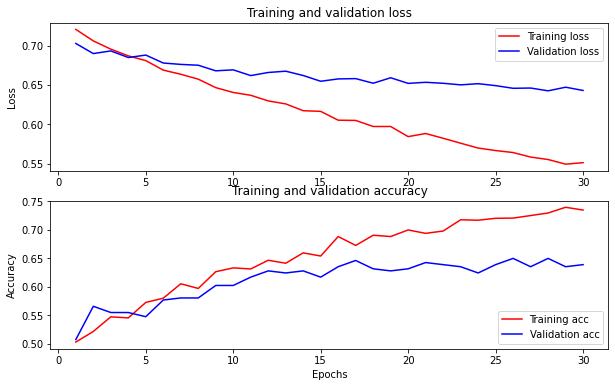

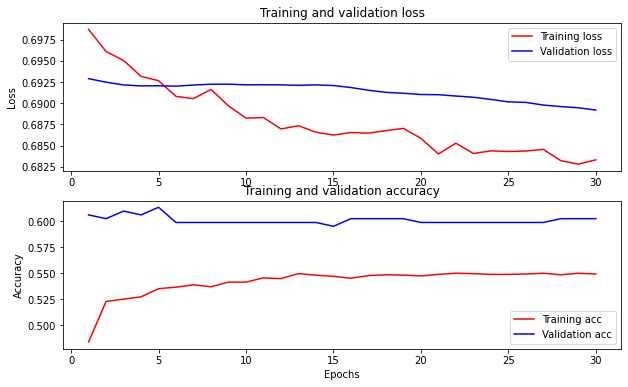

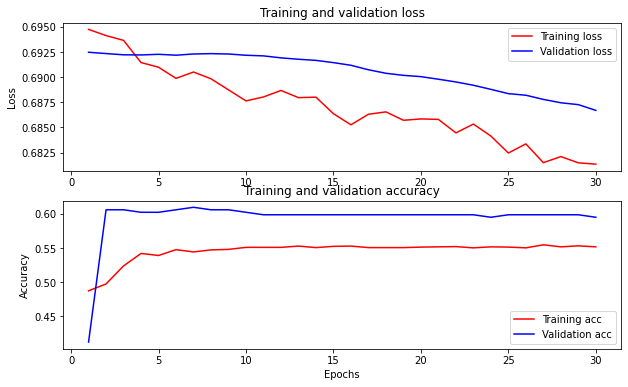

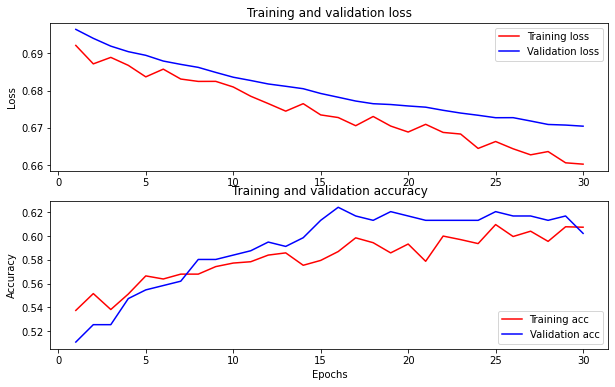

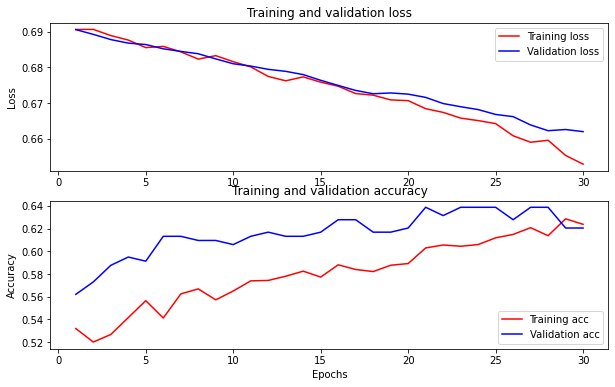

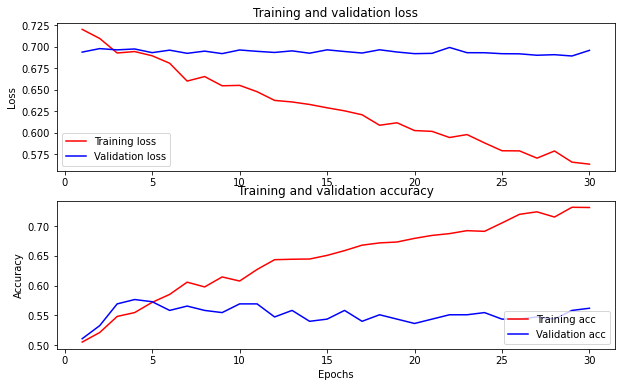

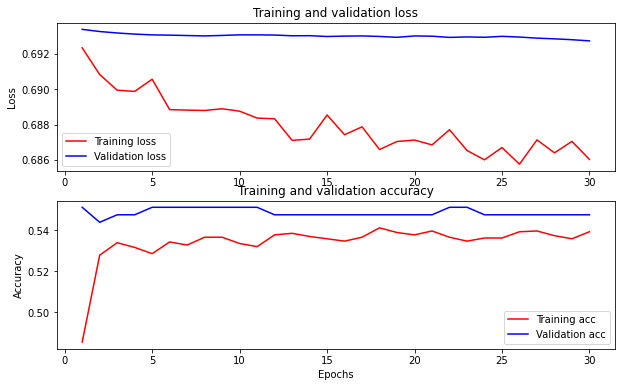

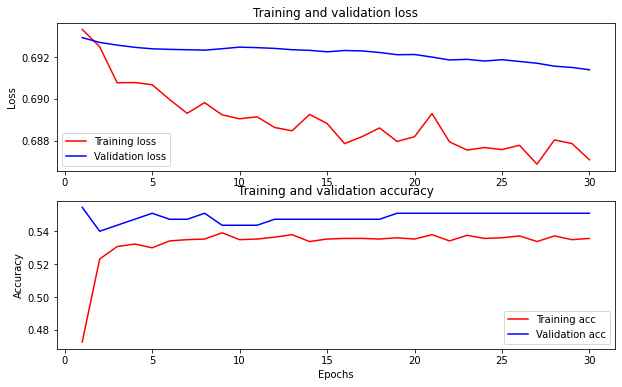

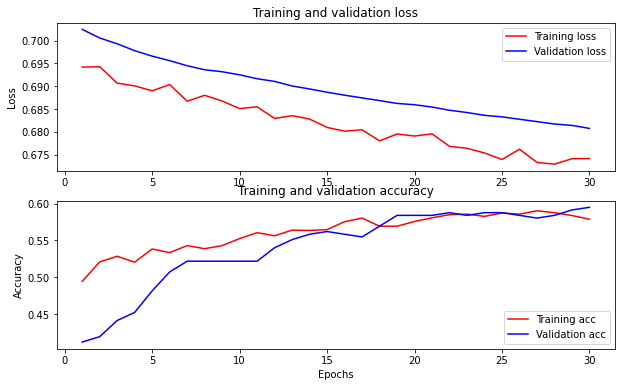

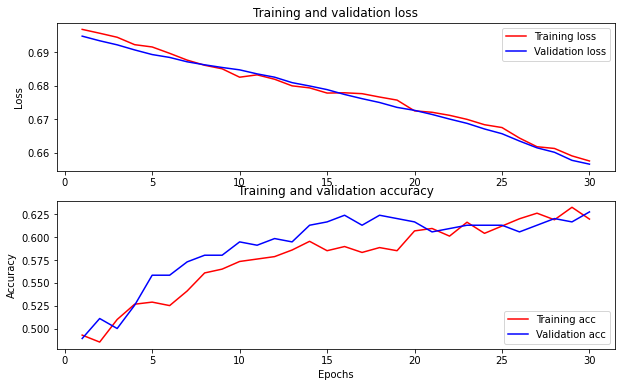

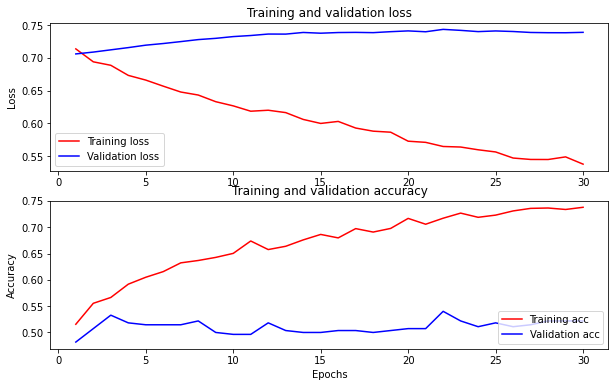

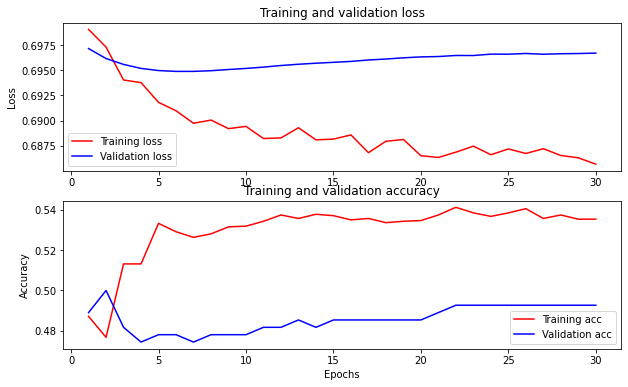

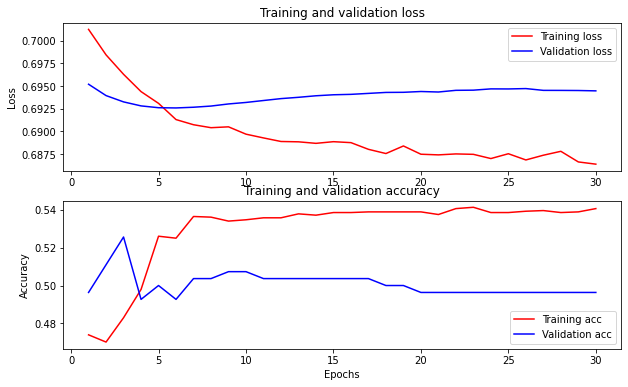

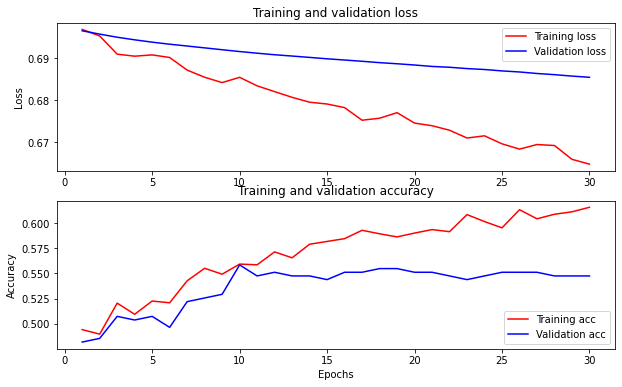

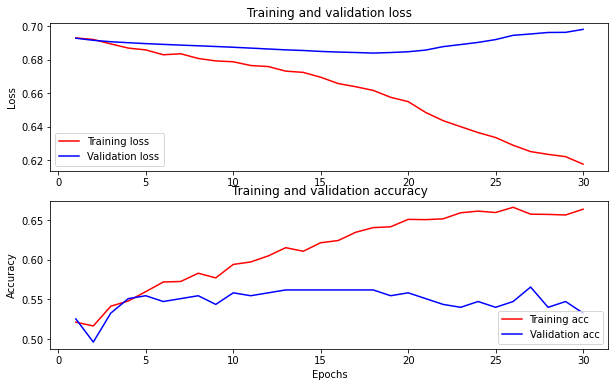

: 

In [12]:
timesteps: list  = [30, 60, 90]
models: list = ['cnn', 'lstm', 'stacked_lstm', 'bilstm', 'stacked_bilstm']
def run_timestep():
    for timestep in timesteps:
         X_TRAIN_DIR, X_VAL_DIR, X_TEST_DIR, Y_TRAIN_DIR, Y_VAL_DIR, Y_TEST_DIR, EMBEDDING_MATRIX_DIR, VOCAB_DIR, TRAIN_CORPORA_DIR = load_variables(timestep)
         print(f"x_train_dir: {X_TRAIN_DIR}")
         print(f"x_val_dir: {X_VAL_DIR}")
         print(f"x_test_dir: {X_TEST_DIR}")
         print(f"y_train_dir: {Y_TRAIN_DIR}")
         print(f"y_val_dir: {Y_VAL_DIR}")
         print(f"y_test_dir: {Y_TEST_DIR}")
         print("-----")

         x_train, y_train, x_val, y_val, x_test, y_test, embedding_matrix, embedding_layer =  get_variables(X_TRAIN_DIR = X_TRAIN_DIR, X_VAL_DIR = X_VAL_DIR, X_TEST_DIR = X_TEST_DIR, Y_TRAIN_DIR = Y_TRAIN_DIR, Y_VAL_DIR = Y_VAL_DIR, Y_TEST_DIR = Y_TEST_DIR, EMBEDDING_DIR = EMBEDDING_MATRIX_DIR,)
         x_train,y_train = balance_training_dataset(x_train, y_train)

         file_suffix: str = f'_i1_o{timestep}'
         for model in models:
            accuracy, loss = run_model(model_type=model, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_test = x_test, y_test = y_test, embedding_layer= embedding_layer, file_suffix = file_suffix, timestep = timestep)
            print(f'Evaluation for {model}')
            print(f'Loss: {loss}')
            print(f'Accuracy: {accuracy}')
run_timestep()